In [1]:
# Adapted from: Chapter 7 and 8 of Deep Learning with Pytorch by Eli Stevens (2020)
try:
    import torch as t
    import torch.nn as tnn
except ImportError:
    print("Colab users: pytorch comes preinstalled. Select Change Ru")
    print("Local users: Please install pytorch for your hardware using instructions from here: https://pytorch.org/get-started/locally/")
    print("ACG users: Please follow instructions here: https://vikasdhiman.info/ECE490-Neural-Networks/posts/0000-00-06-acg-slurm-jupyter/")
    
    raise

if t.cuda.is_available():
    DEVICE="cuda"
    t.cuda.set_device(t.device('cuda:0'))
else:
    DEVICE="cpu"

    
DTYPE = t.get_default_dtype()
print(f"Using {DEVICE=} and {DTYPE=}")

Using DEVICE='cuda' and DTYPE=torch.float32


In [2]:
# imports
import torch.nn
import torch.optim
import torchvision
from torchvision.transforms import Compose, Normalize, Resize
from torchvision.transforms.functional import to_tensor
from torch.utils.data import DataLoader, Dataset
from glob import glob
from PIL import Image
import re
import random
from pathlib import Path

In [3]:

# create a custom dataset for the images
class BiomeDataset(Dataset):
    """
    Dataset for the minecraft biome images
    """
    def __init__(self, data_dir: str, dir_is_paths=False, id_convert_dict=None):
        """
        Arguments:
            data_dir (str): Path to root data directory
            dir_is_paths (bool): If true, interprets data_dir as a list of images
        """
        # init transform to none
        self.transform = None

        if id_convert_dict is not None:
            self.id_to_class = id_convert_dict

        if dir_is_paths:
            self.paths = data_dir
            return
    
        # get the number of images in the dataset
        self.paths = glob(f"{data_dir}/*/*")
        dirs = glob(f"{data_dir}/*")

        self.id_to_class = {} # dictionary which converts a biome id to its class number
        self.data = []  # 2d array. First index indexes biome, second index indexes images
        for i, d in enumerate(dirs):
            self.data.append(glob(f"{d}/*"))
            self.id_to_class[int(re.search(r'[0-9]+', d)[0])] = i

        print(self.id_to_class) 
        print(len(self.id_to_class))   


    def split_data(self, percent_train: float, percent_val: float, seed: int):
        """
        Splits the Dataset per biome into three separate Datasets, 
        one for training, one for validation, and the remainder is for testing.
        """
        train = []
        val = []
        test = []

        rand = random.Random(seed) # TODO: broken af

        # for each biome, randomize the list and then split it
        for b in self.data:
            n_ims = len(b)
            rand.shuffle(b)
            ind1 = int(n_ims * percent_train)
            ind2 = int(n_ims * (percent_train +percent_val))
            train += b[:ind1]
            val += b[ind1:ind2]
            test += b[ind2:]

        return (BiomeDataset(train, dir_is_paths=True, id_convert_dict=self.id_to_class), 
            BiomeDataset(val, dir_is_paths=True, id_convert_dict=self.id_to_class),
            BiomeDataset(test, dir_is_paths=True, id_convert_dict=self.id_to_class))


    def set_transform(self, transform):
        """
        updates the transform that the dataset will use when transforming images
        """
        self.transform = transform


    def __getitem__(self, idx):
        """
        Returns a tuple of (image: ndarray, label: int)
        """

        imname = self.paths[idx]
        image = Image.open(imname)
        image = to_tensor(image).cuda()  # converts to float tensor
        # apply transforms
        if self.transform is not None:
            image = self.transform(image)
    
        label = int(re.search(r'[0-9]+', imname)[0])
        label = self.id_to_class[label]
        return (image, label)


    def __len__(self):
        return len(self.paths)


all_data = BiomeDataset('../scraping/preprocessed_data')

{27: 0, 21: 1, 11: 2, 156: 3, 4: 4, 39: 5, 32: 6, 16: 7, 34: 8, 13: 9, 35: 10, 3: 11, 6: 12, 131: 13, 37: 14, 7: 15, 22: 16, 17: 17, 158: 18, 18: 19, 45: 20, 31: 21, 29: 22, 157: 23, 28: 24, 132: 25, 26: 26, 33: 27, 1: 28, 12: 29, 162: 30, 130: 31, 36: 32, 19: 33, 129: 34, 5: 35, 30: 36, 38: 37, 133: 38, 2: 39, 10: 40}
41


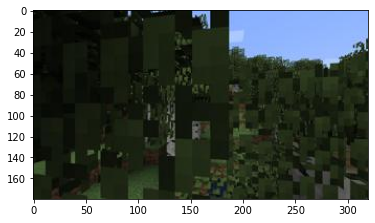

In [4]:
# example image from the dataset
import matplotlib.pyplot as plt
im, label = all_data[3]
plt.imshow(im.cpu().permute(1, 2, 0))

In [5]:
# split up the data
train_data, val_data, test_data = all_data.split_data(0.1, 0.05, 5)
train_data[0][0].shape

torch.Size([3, 180, 320])

In [6]:
# Normalize the data over each channel
DATA_INFO_FILE = "dataset_info.txt"
if Path(DATA_INFO_FILE).exists():
    print('Loading known dataset information for normalization')
    
    means = torch.Tensor([0, 0, 0])
    std = torch.Tensor([0, 0, 0])
    with open(DATA_INFO_FILE, 'r') as f:
        m = f.readline().replace('\n', '').split(' ')
        means[0] = float(m[0])
        means[1] = float(m[1])
        means[2] = float(m[2])
        s = f.readline().replace('\n', '').split(' ')
        std[0] = float(s[0])
        std[1] = float(s[1])
        std[2] = float(s[2]) 
        print("Loaded means", m)
        print("Loaded std", s)

else:
    # compute the means across each channel for the whole training dataset
    means = torch.Tensor([0, 0, 0]).cuda()
    for i in range(len(train_data)):
        im = train_data[i][0]
        means += torch.mean(im, dim=[1,2]) 
        if i % 1000 == 0:
            print(f"Calculating dataset means: {i}/{len(train_data)}")

    means = means / i

    print(means)

    # compute the stdev across each channel for the whole training dataset
    sumel = 0.0
    countel = 0
    for i in range(len(train_data)):
        img = train_data[i][0]
        img = (img - means.unsqueeze(1).unsqueeze(1))**2
        sumel += img.sum([1, 2])
        countel += torch.numel(img[0])
        if i % 1000 == 0:
            print(f"Calculating dataset stdevs: {i}/{len(train_data)}")

    std = torch.sqrt(sumel/countel)

    print(std)

    # save dataset info so that it doesn't need to be recalculated
    with open(DATA_INFO_FILE, 'w') as f:
        f.write(f"{means[0]} {means[1]} {means[2]}\n")
        f.write(f"{std[0]} {std[1]} {std[2]}\n")
        
# normalize the training and validation datasets based on the mean and stedv 
# of the training dataset
# IMAGE_SIZE = (720//10, 1280//10)
transform_img = Compose([
    # Resize(IMAGE_SIZE, antialias=True), # ensure all images are the proper size
    Normalize(mean=means, std=std)
])

train_data.set_transform(transform_img)
val_data.set_transform(transform_img)
test_data.set_transform(transform_img)

Loading known dataset information for normalization
Loaded means ['-0.001346253091469407', '0.0032549926545470953', '0.0027373507618904114']
Loaded std ['0.9920457601547241', '0.989689826965332', '0.9903700351715088']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


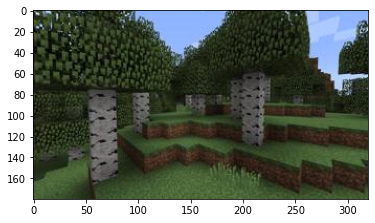

In [7]:
# now a glance at the normalized data. 
im, label = train_data[1]
plt.imshow(im.cpu().permute(1, 2, 0))

In [8]:
# Hyperparameters
batch_size = 64
learning_rate = 1e-3
epochs = 100
momentum = 0.9


# Create the dataloaders. drop_last=True ignores the last, incomplete batch for evaluation compatibility
training_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
validation_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True, drop_last=True)

In [9]:
# Model definition
loss = torch.nn.CrossEntropyLoss()

class ConvNeuralNet(tnn.Module):
    #  Determine what layers and their order in CNN object
    # Code from https://blog.paperspace.com/writing-cnns-from-scratch-in-pytorch/
    def __init__(self, num_classes):
        super(ConvNeuralNet, self).__init__()
        self.conv_layer1 = tnn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding='same')
        self.conv_layer2 = tnn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding='same')
        self.max_pool1 = tnn.MaxPool2d(kernel_size = 2, stride = 2)
        
        self.conv_layer3 = tnn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding='same')
        self.conv_layer4 = tnn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding='same')
        self.max_pool2 = tnn.MaxPool2d(kernel_size = 2, stride = 2)
        
        self.fc1 = tnn.Linear(115200, 128)
        self.relu1 = tnn.ReLU()
        self.fc2 = tnn.Linear(128, num_classes)
    
    # Progresses data across layers    
    def forward(self, x):
        out = self.conv_layer1(x)
        out = self.conv_layer2(out)
        out = self.max_pool1(out)
        
        out = self.conv_layer3(out)
        out = self.conv_layer4(out)
        out = self.max_pool2(out)
                
        out = out.reshape(out.size(0), -1)
        
        out = self.fc1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        return out

    # Get model results for inputs
    def step(self, inputs):
        data, labels = inputs
        outputs = self(data)
        _, preds = torch.max(outputs.data , 1)
        return preds, labels
    
    # get predictions for entire dataloader
    def predict(self, dataloader):
        predictions = torch.Tensor()
        labels = torch.Tensor()
        self.eval() # put in eval mode
        for i, batch in enumerate(dataloader):
            pred, label = self.step(batch)
            predictions = torch.cat((predictions, pred.cpu()))
            labels = torch.cat((labels, label.cpu()))
        return predictions, labels
    
    
model = ConvNeuralNet(55)
model.cuda()

# Define optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

# check what device model is being stored on
print("Is cuda being used for the model?", all([p.is_cuda for p in model.parameters()]))

Is cuda being used for the model? True


In [10]:
from torch.utils.tensorboard import SummaryWriter
import os, datetime
writer = SummaryWriter()

def loss_and_accuracy(model, loss, validation_dataloader, device=DEVICE):
        # Validation loop
        validation_size = len(validation_dataloader.dataset)
        num_batches = len(validation_dataloader)
        test_loss, correct = 0, 0
        
        with torch.no_grad():
            model.eval() # Put model in eval mode, affects layers like dropout and batchnorm
            for X, y in validation_dataloader:
                X = X.to(device)
                y = y.to(device)
                pred = model(X)
                test_loss += loss(pred, y)
                correct += (pred.argmax(dim=-1) == y).type(DTYPE).sum()

        test_loss /= num_batches
        correct /= validation_size
        return test_loss, correct
    
def train(model, loss, training_dataloader, validation_dataloader, device=DEVICE, chkpt_name='model_ckpt.pt', ignore_chkpt=False):
    model.to(device)
    t0 = 0
    if not ignore_chkpt and os.path.exists(f"runs/{chkpt_name}"):
        checkpoint = torch.load(f"runs/{chkpt_name}")
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        t0 = checkpoint['epoch']
    
    for t in range(t0, epochs):
        # Train loop
        training_size = len(training_dataloader.dataset)
        nbatches = len(training_dataloader)
        model.train() # Put model in train mode, affects layers like dropout and batchnorm
        for batch, (X, y) in enumerate(training_dataloader):
            X = X.to(device)
            y = y.to(device)
            # Compute prediction and loss
            pred = model(X)
            loss_t = loss(pred, y)

            # Backpropagation
            optimizer.zero_grad()
            loss_t.backward()
            optimizer.step()

            if batch % 1 == 0:
                writer.add_scalar("Train/loss_batch", loss_t,  t*nbatches + batch)
                loss_t, current = loss_t.item(), (batch + 1) * len(X)
                print(f"loss: {loss_t:>7f}  [{current:>5d}/{training_size:>5d}]", end="\r")
                
        writer.add_scalar("Train/loss", loss_t, t)
        valid_loss, correct = loss_and_accuracy(model, loss, validation_dataloader, device=device)
        writer.add_scalar("Valid/loss", valid_loss, t)
        writer.add_scalar("Valid/accuracy", correct, t)
        print(f"Validation Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {valid_loss:>8f}. Epoch {i}/{epochs} \n")
        if t % 3 == 0:
            torch.save({
                'epoch': t,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict()
                }, f"runs/{chkpt_name}")
    return model
        
    
print(f"Training model using device {DEVICE}. Started at {datetime.datetime.now()}")
trained_model = train(model, loss, training_dataloader, validation_dataloader, chkpt_name='linear_model_chkpt.pt', ignore_chkpt=True)

#test_loss, correct = loss_and_accuracy(model, loss, test_dataloader)
#print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

Training model using device cuda. Started at 2023-04-19 17:38:03.580083
Validation Error: 2176/ 2201]
 Accuracy: 6.9%, Avg loss: 3.243115 

Validation Error: 2176/ 2201]
 Accuracy: 10.9%, Avg loss: 3.009729 

Validation Error: 2176/ 2201]
 Accuracy: 24.2%, Avg loss: 2.828648 

Validation Error: 2176/ 2201]
 Accuracy: 29.2%, Avg loss: 2.636235 

Validation Error: 2176/ 2201]
 Accuracy: 29.5%, Avg loss: 2.543490 

Validation Error: 2176/ 2201]
 Accuracy: 31.2%, Avg loss: 2.431946 

Validation Error: 2176/ 2201]
 Accuracy: 29.3%, Avg loss: 2.423363 

Validation Error: 2176/ 2201]
 Accuracy: 34.3%, Avg loss: 2.343222 

Validation Error: 2176/ 2201]
 Accuracy: 34.2%, Avg loss: 2.343412 

Validation Error: 2176/ 2201]
 Accuracy: 36.7%, Avg loss: 2.231576 

Validation Error: 2176/ 2201]
 Accuracy: 38.8%, Avg loss: 2.229360 

Validation Error: 2176/ 2201]
 Accuracy: 40.7%, Avg loss: 2.146902 

Validation Error: 2176/ 2201]
 Accuracy: 43.5%, Avg loss: 2.107199 

Validation Error: 2176/ 2201]
 A

In [11]:
# Evaluate the model

def per_class_accuracies(predictions, labels):
    """
    Calculates the accuracy for each class
    """ 
    # sort both arrays by the true labels
    labels, inds = torch.sort(labels)
    predictions = predictions[inds]
    
    # populate "accuracies" dict with true predictions, n predictions
    accuracies = {}
    accuracy = 0 # also calculate total accuracy
    for i, l in enumerate(labels):
        l = int(l)
        if not l in accuracies.keys():
            accuracies[l] = [0, 0]
        grade = int(l == int(predictions[i])) # 1 if correct, 0 if incorrect
        accuracy += grade
        accuracies[l] = [accuracies[l][0] + grade, accuracies[l][1] + 1]
        
    # calculate accuracies for each class
    for l, vals in accuracies.items():
        accuracies[l] = vals[0] / vals[1]
    accuracy /= len(labels)
        
    return accuracies, accuracy
    

pred, labels = model.predict(training_dataloader)
accuracies, accuracy = per_class_accuracies(pred, labels)

print("Overall accuracy:", accuracy)
print("Accuracy by class:\n", accuracies)

Overall accuracy: 1.0
Accuracy by class:
 {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0, 7: 1.0, 8: 1.0, 9: 1.0, 10: 1.0, 11: 1.0, 12: 1.0, 13: 1.0, 14: 1.0, 15: 1.0, 16: 1.0, 17: 1.0, 19: 1.0, 20: 1.0, 21: 1.0, 22: 1.0, 23: 1.0, 24: 1.0, 25: 1.0, 26: 1.0, 27: 1.0, 28: 1.0, 29: 1.0, 30: 1.0, 31: 1.0, 32: 1.0, 33: 1.0, 34: 1.0, 35: 1.0, 36: 1.0, 37: 1.0, 38: 1.0, 39: 1.0, 40: 1.0}
